## Building Decision Tree for Classification Tasks

### 3rd Party Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Orange
import pandas as pd
from graphviz import Digraph
from pandas_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use("ggplot")

### Helper Functions for Tidying Data, Dimensionality Reduction, Tree Visualization, Performance Evaluation

In [2]:
def decompose_dataset(table):
    return table.X, table.Y, table.domain.class_var.values


def table2dataframe(table):
    def map_values(vals, real):
        return [real[i] for i in vals]

    attributes = [attr.name for attr in table.domain.attributes]
    target = table.domain.class_var.name

    X, y, _ = decompose_dataset(table)

    return table, pd.DataFrame(data=np.c_[X, y], columns=attributes + [target])


def pca(dataset):
    X, y, target_names = decompose_dataset(dataset)

    pca = PCA(n_components=2)
    X_r = pca.fit_transform(X)

    # Percentage of variance explained for each components
    explained_var = sum(pca.explained_variance_ratio_)

    return X_r, y, target_names, explained_var


def tsne(dataset, itr=1000):
    X, y, target_names = decompose_dataset(dataset)

    tsne = TSNE(n_components=2, n_iter=itr)

    X_r = tsne.fit_transform(X)

    return X_r, y, target_names


def plot_dim_reduce(X_r, y, target_names, ax=None, palette="tab10", **kwargs):
    if not ax:
        ax = plt.gca()

    uniq_target = set(y)
    colors = plt.get_cmap(palette)(np.arange(len(uniq_target), dtype=int))
    lw = 2

    for color, i, target_name in zip(colors, uniq_target, target_names):
        ax.scatter(
            X_r[y == i, 0],
            X_r[y == i, 1],
            color=color,
            alpha=0.8,
            lw=lw,
            label=target_name,
        )

    ax.legend(loc="best", shadow=True, scatterpoints=1)
    ax.set_xlabel(kwargs["xtitle"])
    ax.set_ylabel(kwargs["ytitle"])
    ax.set_title(kwargs["title"])


def plot_pca_tsne(dataset, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    X_r_pca, y, target_names, explained_var = pca(dataset)
    title1 = "{} -- Total Variation: %{:.3f}".format(name, explained_var)
    plot_dim_reduce(
        X_r_pca, y, target_names, axes[0], xtitle="PC 1", ytitle="PC 2", title=title1
    )

    X_r_tsne, _, _ = tsne(dataset)
    title2 = "{} -- TSNE Visualization".format(name)
    plot_dim_reduce(
        X_r_tsne, y, target_names, axes[1], xtitle="Dim 1", ytitle="Dim 2", title=title2
    )

    fig.tight_layout(pad=5.0)


def class_dist(num_obs, labels, justified="\l"):
    dist = np.array(num_obs) / sum(num_obs)
    dist_labels = dict(zip(labels, dist))

    return justified.join(["{} = {:.3f}".format(k, v) for k, v in dist_labels.items()])


def visualize_tree(tree, labels):
    def visualize_tree_aux(root, labels, dot=None):
        if not dot:
            dot = Digraph()
            dot.attr("node", shape="record")
            desc = class_dist(root.value, labels)
            dot.node(name=str(root), label="{{{}|{}}}".format(desc, root.attr.name))

        for child in root.children:
            attr = child.attr
            desc = class_dist(child.value, labels)
            if attr:
                dot.node(name=str(child), label="{{{}|{}}}".format(desc, attr.name))
                dot.edge(str(root), str(child), label=child.description)
            else:
                dot.node(name=str(child), label="{{{}|{}}}".format(desc, ""))
                dot.edge(str(root), str(child), label=child.description)

            visualize_tree_aux(child, labels, dot)

        return dot

    return visualize_tree_aux(tree.root, labels)

def evaluate_performance(test, pred):
    result = Orange.evaluation.Results()
    result.actual = test.Y
    result.predicted = [pred]

    ca = Orange.evaluation.CA()

    return ca(result)[0]

### Exploratory Data Analysis

In [3]:
dataset, df = table2dataframe(Orange.data.Table("iris"))
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
profile.to_widgets()

### Dimensionality Reduction Plots

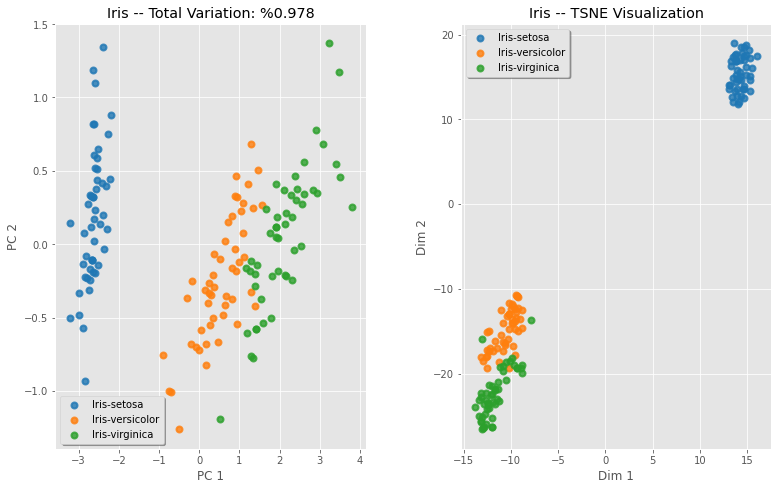

In [4]:
plot_pca_tsne(dataset, "Iris")

### Building Decision Tree Model, Training and Testing Data Split

       [40.  0.  0.] petal length ≤ 1.9
       [ 0. 40. 40.] petal length > 1.9
       [ 0. 40.  5.]     petal width ≤ 1.7
       [ 0. 40.  3.]         petal length ≤ 5.1
       [ 0. 38.  1.]             petal length ≤ 4.9
          [0. 2. 2.]             petal length > 4.9
          [0. 0. 2.]                 petal width ≤ 1.5
          [0. 2. 0.]                 petal width > 1.5
          [0. 0. 2.]         petal length > 5.1
       [ 0.  0. 35.]     petal width > 1.7



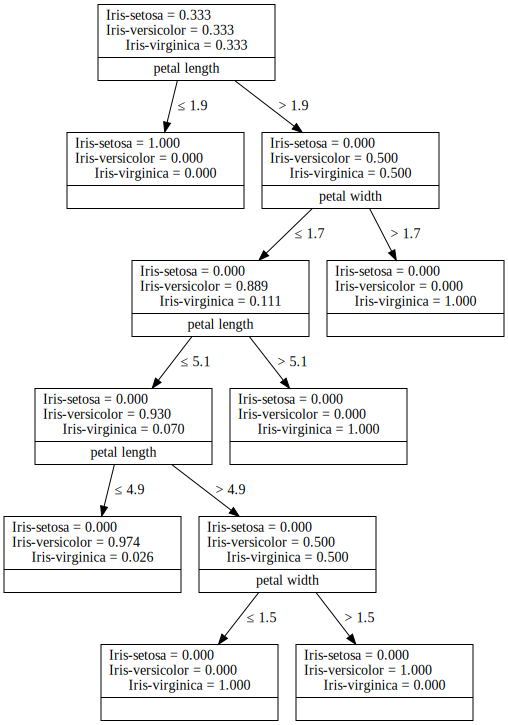

In [5]:
training, testing = Orange.evaluation.testing.sample(
    dataset, n=0.8, stratified=True, replace=False
)
assert len(training) + len(testing) == len(dataset)

learner = Orange.classification.TreeLearner()
dt = learner(training)

print(dt.print_tree())
visualize_tree(dt, list(training.domain.class_var.values))

### Evaluating Model

In [6]:
y_pred = dt(testing)

acc = evaluate_performance(testing, y_pred)
print("Classification Accuracy = {:.3f}".format(acc))

Classification Accuracy = 0.967


In [7]:
# from PyQt5.QtWidgets import *
# from PyQt5.QtGui import *
# from PyQt5.QtCore import *

# import numpy as np

# from Orange.widgets.utils.widgetpreview import WidgetPreview
# from Orange.widgets.visualize.owtreeviewer import OWTreeGraph
# from Orange.widgets.unsupervised.owtsne import OWtSNE

# import sys
# if not QApplication.instance():
#     app = QApplication(sys.argv)
# else:
#     app = QApplication.instance() 

# WidgetPreview(OWTreeGraph).run(classifier)
# WidgetPreview(OWtSNE).run(set_data=iris, set_subset_data=iris[np.random.choice(len(iris), 2)])

# QApplication.setQuitOnLastWindowClosed(True)
# app.exec_()
# app.quit()

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

Please contact Haluk Dogan (<a href="mailto:hdogan@vivaldi.net">hdogan@vivaldi.net</a>) for further questions or inquries.